In [8]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from keras.models import load_model
from keras.metrics import Precision, Recall
from keras.callbacks import CSVLogger, EarlyStopping
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

!pip install transformers
!pip install sentencepiece
from transformers import PreTrainedTokenizerBase, RobertaTokenizer, TFRobertaModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import nltk
import matplotlib.pyplot as plt

from re import sub
from pandas import DataFrame
from tabulate import tabulate
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from typing import Union, List, Tuple
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pandas.io.parsers import TextFileReader
from collections import Counter

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download('punkt')
__STOPWORDS = stopwords.words("english")
STEMMER = PorterStemmer()
LEMMATIZER = WordNetLemmatizer()


def process_data(text: str, do_stemming: bool = False, do_lemmas: bool = False, do_lowercase: bool = False) -> str:
    """
    @param text: The text to process. It will remove the money amounts, retweets, links,
                 hashtags, punctuation and it will lowercase all the words
    @param do_stemming: Steam words to have less in vocabulary if set to true
    @param do_lowercase: Lowercase input text if set to true
    @param do_lemmas: Lemmatize word to be at a dictionary representation if true
    @return: The new processed text as a list of words
    """
    text = sub(r" +", " ", text)
    text = sub(r"\S@\S\s?", "", text)
    text = sub(r"[0-9]+(?:.[0-9]+){3}", "", text)
    text = sub(r"\$\w*", "", text)
    text = sub(r"(RT)+", "", text)
    text = sub(r"(lt)+", "", text)
    text = sub(r"(gt)+", "", text)
    text = sub(r"@[a-zA-Z0-9\_]+", "", text)
    text = sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)", "", text)
    text = sub(r"#", "", text)
    text = sub(r"\d+", "", text)
    text = sub("[^A-Za-z0-9]+", " ", text)  # also removes special characters since they are not alphanumeric
    if do_lowercase:
        text = text.lower()

    # tokenized_data = __TOKENIZER.tokenize(text)
    tokenized_data = word_tokenize(text)
    processed_data = []

    for word in tokenized_data:
        if word not in __STOPWORDS and word not in punctuation:
            if do_stemming and not do_lemmas:
                word = STEMMER.stem(word)
            elif do_lemmas and not do_stemming:
                word = LEMMATIZER.lemmatize(word)
            elif do_lemmas and do_stemming:
                raise ValueError(
                    f"Can't do both lemmatizing and stemming. Values for do_lemmas={do_lemmas} "
                    f"and do_stemming={do_stemming} cannot be true for both."
                )
            processed_data.append(word)

    return " ".join(processed_data)


def plot_train_data(csv_data: Union[TextFileReader, DataFrame], train_metric: str, validation_metric: str) -> None:
    plt.figure()
    plt.plot(csv_data[train_metric], color="blueviolet")
    plt.plot(csv_data[validation_metric], color="green")
    plt.title(f"{train_metric.capitalize()} over epochs")
    plt.legend(["train", "validation"])
    plt.xlabel("epoch")
    plt.ylabel(train_metric)
    plt.grid(visible=True)


def display_train_report_and_f1_score(csv_data: Union[TextFileReader, DataFrame]) -> None:
    headers = ["epoch", "accuracy", "loss", "precision", "recall"]
    train_rep = csv_data[csv_data["epoch"] == len(csv_data) - 1][headers]
    precision = train_rep["precision"].iloc[0]
    recall = train_rep["recall"].iloc[0]
    f1_score = 2 * precision * recall / (precision + recall)
    train_rep["f1_score"] = f1_score
    rep_data = train_rep.values.tolist()
    print('\033[92m')
    print("╒═════════════════╕")
    print("│ Training Report │")
    print(tabulate(rep_data, headers=[header.capitalize() for header in headers] + ["F1 Score"], tablefmt="fancy_grid"))


def display_readable_time(start_time: float, end_time: float) -> None:
    minutes = (end_time - start_time) / 60
    ss = (end_time - start_time) % 60
    hh = minutes / 60
    mm = minutes % 60
    print('\033[94m')
    print(f"Training time: %02d:%02d:%02d | {round(end_time - start_time, 2)} seconds" % (hh, mm, ss))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!mkdir train_local
# !wget /content/drive/MyDrive/dataset/abusive-language/vidgen-wassem-davidson-founta-zampieri.zip
!unzip /content/drive/MyDrive/dataset/abusive-language/vidgen-wassem-davidson-founta-zampieri.zip -d /content/train_local

mkdir: cannot create directory ‘train_local’: File exists
Archive:  /content/drive/MyDrive/dataset/abusive-language/vidgen-wassem-davidson-founta-zampieri.zip
replace /content/train_local/dynamically-hate-vidgen/Dynamically Generated Hate Dataset - annotation guidelines.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/train_local/dynamically-hate-vidgen/Dynamically Generated Hate Dataset - annotation guidelines.pdf  
replace /content/train_local/dynamically-hate-vidgen/Dynamically_Generated_Hate_Dataset_v0.2.2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: all
error:  invalid response [all]
replace /content/train_local/dynamically-hate-vidgen/Dynamically_Generated_Hate_Dataset_v0.2.2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: /content/train_local/dynamically-hate-vidgen/Dynamically_Generated_Hate_Dataset_v0.2.2.csv  
  inflating: /content/train_local/dynamically-hate-vidgen/Dynamically_Generated_Hate_Dataset_v0.2.3.csv  
  inflating: /content/train_loca

In [12]:
# TODO: Update these with the google stuff
DAVIDSON_DIR = os.path.join("/content/train_local", "hatespeech-davidson")
DAVIDSON_DIR = os.path.join(DAVIDSON_DIR, "data")
DATASET_PATH = os.path.join(DAVIDSON_DIR, "labeled_data.csv")
DAVIDSON_MODEL_LOGS_PATH = os.path.join("/content/drive/MyDrive/nlp-models/abusive-language/logs", "davidson")
DAVIDSON_MODEL_PATH = os.path.join("/content/drive/MyDrive/nlp-models/abusive-language/models", "davidson")

MODEL_FILE_NAME = "roberta_large_davidson"
ROBERTA_TYPE = "roberta-large"  # roberta-base | roberta-large | roberta-large-mnli

# Clean: 36 | No lowercase: 29 | Lowercase: 28 | Lowercase & Stemming: 28 | Lowercase & Lemmas: 28
MAX_PADDING_LENGTH = 28
LEARNING_RATE = 2e-5
BATCH_SIZE = 32
EPOCHS = 10


In [13]:

def encode_tweet(tweet: str, roberta_tokenizer: PreTrainedTokenizerBase):
    return roberta_tokenizer.encode_plus(
        # tweet,
        # process_data(tweet),
        process_data(tweet, do_stemming=False, do_lemmas=False, do_lowercase=True),
        add_special_tokens=True,
        max_length=MAX_PADDING_LENGTH,
        truncation=True,
        padding="max_length",
        return_attention_mask=True
    )


def encode_tweets(tweets_text: list, tweets_labels, roberta_tokenizer: PreTrainedTokenizerBase):
    if tweets_labels is not None:
        assert len(tweets_text) == len(tweets_labels), f"Features and labels must have the same lengths. " \
                                                       f"Your input ({len(tweets_text)}, {len(tweets_labels)})"

    input_ids = []
    attention_masks = []

    for tweet in tweets_text:
        tweet_for_roberta = encode_tweet(tweet, roberta_tokenizer)
        input_ids.append(tweet_for_roberta["input_ids"])
        attention_masks.append(tweet_for_roberta["attention_mask"])

    if tweets_labels is not None:
        assert len(input_ids) == len(attention_masks) == len(tweets_labels), \
            "Arrays must have the same length."
        return np.array(input_ids), np.array(attention_masks), np.array(tweets_labels)

    return np.array(input_ids), np.array(attention_masks)


def generate_roberta_dict(input_ids, attention_mask) -> dict:
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask
    }


def roberta_tuning(roberta_type: str = ROBERTA_TYPE):
    input_ids = tf.keras.Input(shape=(MAX_PADDING_LENGTH,), name="input_ids", dtype="int32")
    attention_masks = tf.keras.Input(shape=(MAX_PADDING_LENGTH,), name="attention_mask", dtype="int32")

    roberta_model = TFRobertaModel.from_pretrained(roberta_type)
    encodings = roberta_model(input_ids=input_ids, attention_mask=attention_masks)[0]
    last_encoding = tf.squeeze(encodings[:, -1:, :], axis=1)
    # last_encoding = tf.keras.layers.Dropout(0.1)(last_encoding)

    outputs = tf.keras.layers.Dense(3, activation="softmax", name="outputs")(last_encoding)

    temp_model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=outputs)
    temp_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="categorical_crossentropy",
        metrics=["accuracy", Precision(), Recall()]
    )

    return temp_model


In [14]:
tokenizer = RobertaTokenizer.from_pretrained(ROBERTA_TYPE, do_lower_case=True)

df = pd.read_csv(DATASET_PATH, delimiter=",")

train_texts = df["tweet"].tolist()
train_labels = df["class"].tolist()

train_labels = np_utils.to_categorical(train_labels)

X_train, X_temp, y_train, y_temp = train_test_split(train_texts, train_labels, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

train_ids, train_masks, train_labels = encode_tweets(
    tweets_text=X_train,
    tweets_labels=y_train,
    roberta_tokenizer=tokenizer
)
validation_ids, validation_masks, val_labels = encode_tweets(
    tweets_text=X_val,
    tweets_labels=y_val,
    roberta_tokenizer=tokenizer
)
test_ids, test_masks, test_labels = encode_tweets(
    tweets_text=X_test,
    tweets_labels=y_test,
    roberta_tokenizer=tokenizer
)

train_data = generate_roberta_dict(train_ids, train_masks)
validation_data = (generate_roberta_dict(validation_ids, validation_masks), val_labels)
test_data = generate_roberta_dict(test_ids, test_masks)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [15]:
model = roberta_tuning()
print(model.summary())
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2, restore_best_weights=True)
csv_logger = CSVLogger(os.path.join(DAVIDSON_MODEL_LOGS_PATH, f"{MODEL_FILE_NAME}.log"), separator=",",
                        append=False)
start_time = time.time()
hist = model.fit(train_data, train_labels, validation_data=validation_data, epochs=EPOCHS, batch_size=BATCH_SIZE,
                  callbacks=[csv_logger, early_stop])
end_time = time.time()
model.save(os.path.join(DAVIDSON_MODEL_PATH, f"{MODEL_FILE_NAME}.h5"))
display_readable_time(start_time=start_time, end_time=end_time)

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-large were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 28)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 28)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  355359744  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 28,                                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



╒═════════════════╕
│ Training Report │
╒═════════╤════════════╤══════════╤═════════════╤══════════╤════════════╕
│   Epoch │   Accuracy │     Loss │   Precision │   Recall │   F1 Score │
╞═════════╪════════════╪══════════╪═════════════╪══════════╪════════════╡
│       5 │   0.928125 │ 0.197023 │    0.931839 │ 0.924695 │   0.928253 │
╘═════════╧════════════╧══════════╧═════════════╧══════════╧════════════╛


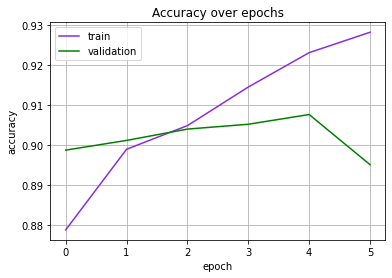

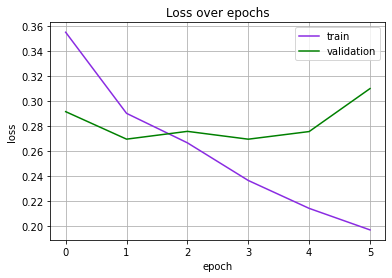

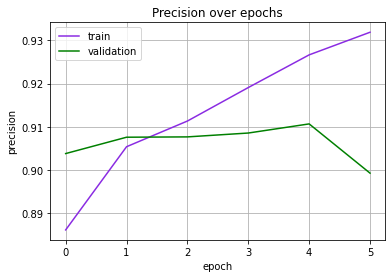

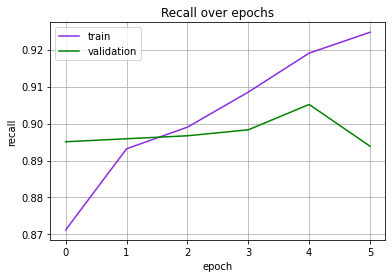

In [16]:
log_data = pd.read_csv(os.path.join(DAVIDSON_MODEL_LOGS_PATH, f"{MODEL_FILE_NAME}.log"), sep=",", engine="python")
display_train_report_and_f1_score(log_data)
plot_train_data(log_data, train_metric="accuracy", validation_metric="val_accuracy")
plot_train_data(log_data, train_metric="loss", validation_metric="val_loss")
plot_train_data(log_data, train_metric="precision", validation_metric="val_precision")
plot_train_data(log_data, train_metric="recall", validation_metric="val_recall")
plt.show()

In [17]:
predictions = model.predict(test_data)

for prediction in predictions:
    for index, pred_class in enumerate(prediction):
        if pred_class == max(prediction):
            prediction[index] = 1
        else:
            prediction[index] = 0

print(predictions)
print(test_labels)
print(len(predictions), len(test_labels))
print(type(test_labels), type(predictions))

print(f"\n{classification_report(test_labels, predictions)}")


[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
2479 2479
<class 'numpy.ndarray'> <class 'numpy.ndarray'>

              precision    recall  f1-score   support

           0       0.49      0.15      0.23       135
           1       0.91      0.98      0.94      1918
           2       0.90      0.81      0.85       426

   micro avg       0.90      0.90      0.90      2479
   macro avg       0.77      0.64      0.67      2479
weighted avg       0.89      0.90      0.89      2479
 samples avg       0.90      0.90      0.90      2479

